In [1]:
import os
import numpy as np
import h5py
import random
import json
import pywt
from PIL import Image
import tensorflow as tf
%pylab inline
from scipy import fftpack, ndimage

Populating the interactive namespace from numpy and matplotlib


/home/ecbm4040/miniconda3/envs/dlenv/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
train_dir = './data/train'
structure_file = 'digitStruct.mat'
train_struct = train_dir+'/'+structure_file
img_files = tf.gfile.Glob(os.path.join(train_dir, '*.png'))
total_cnt = len(img_files)

In [3]:
print(type(img_files),img_files[5])

<class 'list'> ./data/train/14063.png


In [4]:
def Encoder_TFrecord(img_file,struct_mat,WT_flag):
    index = int(img_file.split('/')[-1].split('.')[0]) - 1
    attrs = {}
    item = struct_mat['digitStruct']['bbox'][index].item()
    for key in ['label', 'left', 'top', 'width', 'height']:
        attr = struct_mat[item][key]
        values = [struct_mat[attr.value[i].item()].value[0][0]
                  for i in range(len(attr))] if len(attr) > 1 else [attr.value[0][0]]
        attrs[key] = values

    label_digits = attrs['label']
    length = len(label_digits)
    
    # According to the infomation from Data Extract & Analysis, the maximum of digit length is 6
    # Here we use DIGIT 10 to represent there is no digit in the corresponding pos in the fig
    #According to the instruction of the mat file, the LABEL zero is expressed as 10
    digits = [10, 10, 10, 10, 10, 10] 
    for idx, digit in enumerate(label_digits):
        digits[idx] = int(digit if digit != 10 else 0) 

    attrs_left, attrs_top, attrs_width, attrs_height = map(lambda x: [int(i) for i in x], [attrs['left'], attrs['top'], attrs['width'], attrs['height']])
    min_left, min_top, max_right, max_bottom = (min(attrs_left),min(attrs_top),max(map(lambda x, y: x + y, attrs_left, attrs_width)),
                                                max(map(lambda x, y: x + y, attrs_top, attrs_height)))
    center_x, center_y, max_side = ((min_left+max_right)/2.0, (min_top+max_bottom)/2.0, max((max_right-min_left), (max_bottom-min_top)))
    bbox_left, bbox_top, bbox_width, bbox_height = (center_x-max_side/2.0, center_y-max_side/2.0,max_side,max_side)
    cropped_left, cropped_top, cropped_width, cropped_height = (int(round(bbox_left - 0.15 * bbox_width)),int(round(bbox_top - 0.15 * bbox_height)),
                                                                int(round(bbox_width * 1.3)),
                                                                int(round(bbox_height * 1.3)))
    image = Image.open(img_file)
    image = image.crop([cropped_left, cropped_top, cropped_left+cropped_width, cropped_top+cropped_height])
    image = image.resize([64, 64])
    
    test = np.array(image)
    print(test.shape, test.max(), test.min(), type(test[5,5,2]))

    if WT_flag == 1:
        image = wavelet_transform(np.array(image)).tobytes()
    elif WT_flag == 0:
        plt.figure()
        currentAxis = plt.gca()
        currentAxis.imshow(image)
        plt.show()
        rese = np.array(image)
        print(rese.max(),rese.min())
        image = np.array(image).tobytes()

    Processed_Data = tf.train.Example(features=tf.train.Features(feature={
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),
        'length': tf.train.Feature(int64_list=tf.train.Int64List(value=[length])),
        'digits': tf.train.Feature(int64_list=tf.train.Int64List(value=digits))
    }))
    return Processed_Data, test


(64, 64, 3) 223 0 <class 'numpy.uint8'>


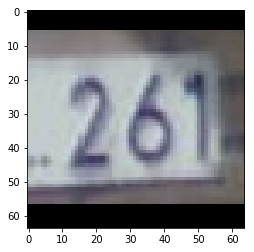

223 0


In [5]:
struct_mat = h5py.File(train_struct, 'r')
for cnt_process, img_file in enumerate(img_files):
    if cnt_process == 25:
        Processed_Data, image_test = Encoder_TFrecord(img_file, struct_mat, 0)

In [6]:
print(type(image_test[5,5,2]),image_test[5,5,2])
image_float = image_test.astype(float)
print(type(image_float[5,5,2]),image_float[5,5,2],image_float.max())

<class 'numpy.uint8'> 0
<class 'numpy.float64'> 0.0 223.0


In [7]:
image_float = image_test.astype(float)
gray = 0.2989 * image_float[:,:,0] + 0.5870 * image_float[:,:,1] + 0.1140 * image_float[:,:,2]
layer1 = gray.astype(numpy.uint8)

T = log(abs(numpy.fft.fftshift(numpy.fft.fft2(gray)))+1)
T = (T-T.min())/(T.max()-T.min())*255
layer2 = T.astype(numpy.uint8)

coeffs2 = pywt.dwt2(layer1, 'haar')
LL, (LH, HL, HH) = coeffs2
UL = (LL-LL.min())/(LL.max()-LL.min())*255
DL = (HL-HL.min())/(HL.max()-HL.min())*255
UR = (LH-LH.min())/(LH.max()-LH.min())*255
DR = (HH-HH.min())/(HH.max()-HH.min())*255

UL = UL.astype(numpy.uint8)
DL = DL.astype(numpy.uint8)
UR = UR.astype(numpy.uint8)
DR = DR.astype(numpy.uint8)

layer3 = np.zeros((64,64),dtype='uint8')
layer3[:32,:32] = UL
layer3[:32,32:] = DL
layer3[32:,:32] = UR
layer3[32:,32:] = DR

output = np.zeros((64,64,3),dtype='uint8')
output[:,:,0] = layer1
output[:,:,1] = layer2
output[:,:,2] = layer3


print(layer1.shape, layer1.max(), layer1.min(), type(layer1[5,5]))
print(layer2.shape, layer2.max(), layer2.min(), type(layer2[5,5]))
print(layer3.shape, layer3.max(), layer3.min(), type(layer3[5,5]))
print(output.shape, output.max(), output.min(), type(output[5,5,2]))

(64, 64) 213 0 <class 'numpy.uint8'>
(64, 64) 255 0 <class 'numpy.uint8'>
(64, 64) 255 0 <class 'numpy.uint8'>
(64, 64, 3) 255 0 <class 'numpy.uint8'>


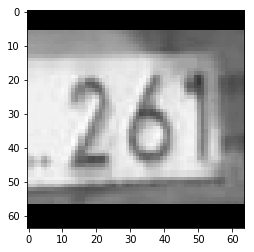

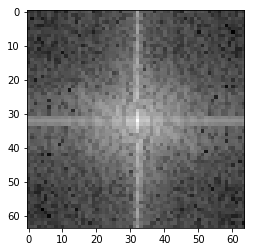

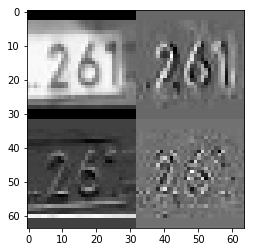

In [8]:


plt.imshow(layer1,cmap=plt.cm.gray)
plt.show()
plt.imshow(layer2,cmap=plt.cm.gray)
plt.show()
plt.imshow(layer3,cmap=plt.cm.gray)
plt.show()


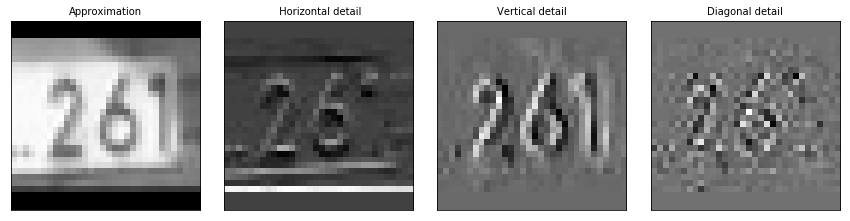

In [9]:
import numpy as np
import matplotlib.pyplot as plt

import pywt
import pywt.data


# Load image
original = pywt.data.camera()

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(layer1, 'haar') #bior1.3
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()